
## 1. Neural Networks are Mathematical Expression
which its
- input: 1) input data, 2) weights of neural network
- output: prediction

> my claim is that micrograd is what you need to train your networks and everything else is just efficiency



## 2. Think of derivative just as a tiny step

You need to have a very good understanding of what a derivative is

> if you slightly bump up you're at some point $x$ that you're interested in or a and if you slightly bump up you know you slightly increase it by small number $h$ how does the function respond with what sensitivity does it respond what is the slope at that point does the function go up or does it go down and by how much and that's the slope of that function the the slope of that response at that point and so we can basically evaluate the derivative here numerically by taking a very small $h$

In [1]:
# in code expression, h is just a small number which represents a tiny step
h = 0.0001

a = -2
b = 3
c = 2

d1 = a * b + c
a+=h
d2 = a * b + c

print("d1: ", d1)
print("d2: ", d2)
print("slope\n= (d2-d1)/h \n= {(a+h)*b+c-(a*b+c)}/h\n= bh/b\n= b =", (d2-d1)/h)

d1:  -4
d2:  -3.9997
slope
= (d2-d1)/h 
= {(a+h)*b+c-(a*b+c)}/h
= bh/b
= b = 3.00000000000189


We can easily calculate why b becomes 3.

$d_2-d_1 = h*b$
$h * b / h = b$
Therefore the gradient is b

On the other hand if we check the gradient of b, it will be a.

## 3. Value Class

In [2]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Vaule(data={self.data})"

In [3]:
Value(2.0) + Value(4.0)

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

We need to configure a special function for Value instances to add them.

In [4]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._children = _children
        self._op = _op

    def __repr__(self):
        return f"Vaule(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

In [5]:
Value(2.0) + Value(4.0)

Vaule(data=6.0)

Now let's manually backpropagate...

In [27]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) # error happened because i didn't use 'set' here !!
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Vaule(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Vaule(data=-8.0)

graphviz is just an opensource visualizing tool, which in this case shows a tree-like data structure which the final Loss (L) as the root.

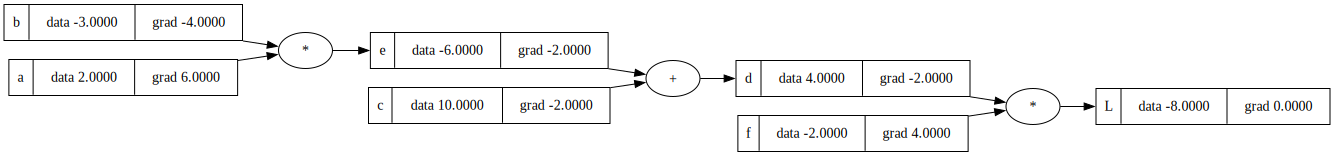

In [60]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label ="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
    
draw_dot(L)

Now let's manually back propagate using lol()

In [37]:
class Value:
    def __init__(self, data, _children=(), _op='', label='', grad=0):
        self.data = data
        self._prev = set(_children) # error happened because i didn't use 'set' here !!
        self._op = _op
        self.label = label
        self.grad = grad

    def __repr__(self):
        return f"Vaule(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Vaule(data=-8.0)

In [43]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data + h
    print((L2-L1)/h)

In [44]:
lol() # derivative of L becomes 1

0.9999999999976694


In [45]:
L.grad = 1

Let's check f now.

$dL/df = \frac{(f+h)*d-f*d}{h} = \frac{d*h}{h} = d = 4$

let's check if lol() gives us the same result:
(since we need to add `h` to f, let's slightly modify the Value Class)

In [49]:
class Value:
    def __init__(self, data, _children=(), _op='', label='', grad=0):
        self.data = data
        self._prev = set(_children) # error happened because i didn't use 'set' here !!
        self._op = _op
        self.label = label
        self.grad = grad

    def __repr__(self):
        return f"Vaule(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Vaule(data=-8.0)

In [50]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')+h
    L = d*f; L.label='L'
    L2 = L.data
    print((L2-L1)/h)
lol()

3.9999999999995595


Our prediction was correct. $d$ will be -2

In [52]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c+h; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    print((L2-L1)/h)
lol()

-1.9999999999953388


Correct!

Let's update the two variable's gradient

In [53]:
f.grad = 4
d.grad = -2

## 4. Chain Rule

> Roughly speaking, if you know how chain rule works, you know how to back propagate all kinds of neural network.

Then how can we calculate the derivative of L in the respect to e?

We introduce what is called Chain Rule in derivative, which is

$dL/de = dL/dd * dd/de$

it's little bit more complicated to mathematically prove it, but you can kind of get the "vibe"

<br>

since d = e + c, $dd/de$ is 1.

this is because $((e+h)+c - (e+c))/h = h/h = 1$

so $dL/de = dL/dd \times 1 = -2$

We can generalize that when operating addition, the grad is the same as($\times 1$) the parent's grad.

Let's check the code again if we're right.

In [55]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b+h; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    print((L2-L1)/h)
lol()

-1.9999999999953388


In [56]:
e.grad = -2
c.grad = -2

Lastly, since $e = a \times b$,

a.grad will be $-3 \times -2 = 6$ and b.grad will be $2 \times -2 = -4$

In [58]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a') + h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    print((L2-L1)/h)
lol()

# b: -4
# a: 6

6.000000000021544


Great.

In [59]:
a.grad = 6
b.grad = -4